In [64]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
import random


1. PCA

In [72]:
def pad_image(img):
  M,N = img.shape
  if M % 8 != 0:
    pad = 8 - M % 8
  img1 = np.pad(img,(2,3),'constant')
  return img1
    


In [137]:
image = Image.open('/content/lighthouse.png').convert('L')
image = np.array(image)
image1 = pad_image(image) # Padding image so it can be divided into 8x8 patches

In [154]:
#dividing and flattening the 8x8 patches
patches = np.zeros((64,int(image1.shape[0]*image1.shape[1]/64)))
count = 0
for i in range(0,image1.shape[0],8):
  for j in range(0,image1.shape[1],8):
    block = image1[i:i+8,j:j+8]
    block = block.flatten()
    patches[:,count] = block
    count+=1


In [155]:
#Shifting the mean to zero
mean = np.mean(patches, axis=1)
patches = (patches.T - mean).T
print(patches.shape)

(64, 7569)


In [166]:
#Extracting the eigen values and eigen vectors
covariance_matrix = np.cov(patches)
e_values,e_vectors = np.linalg.eig(covariance_matrix)
e_vectors = e_vectors.T   

In [174]:
sorted_e_values_idxs = e_values.argsort()[::-1]
levels = [48,32,16,8,4,2]

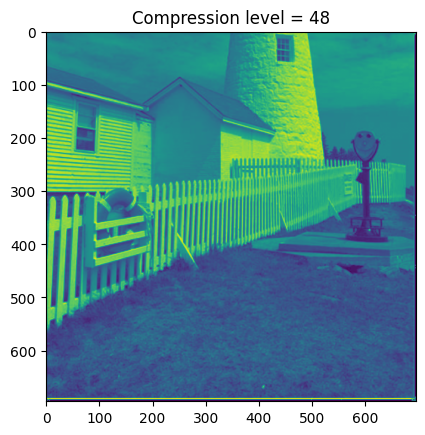

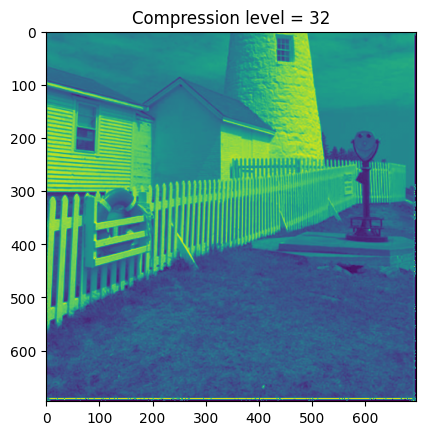

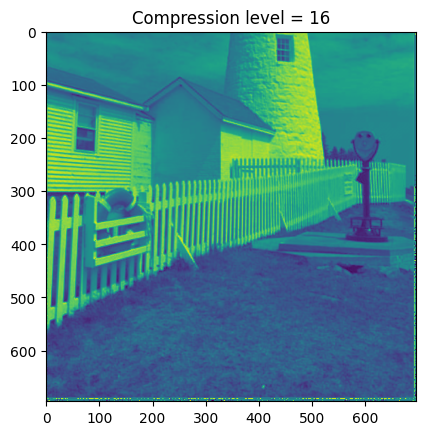

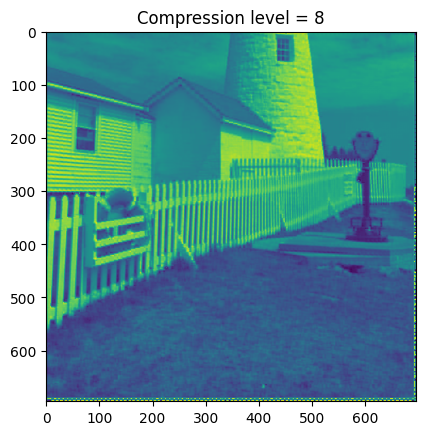

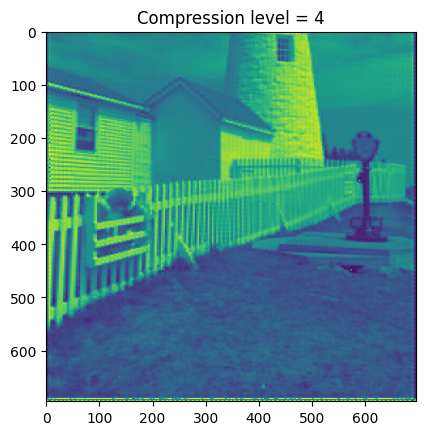

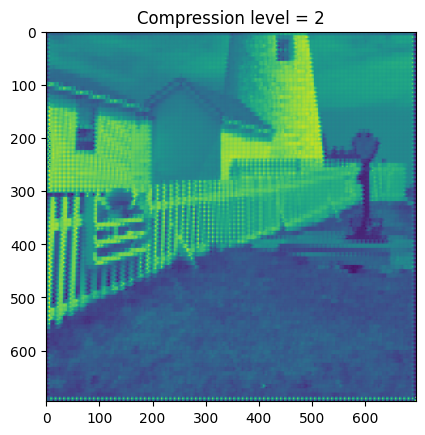

In [175]:
for idx, M in enumerate(levels):
    
    U = e_vectors[sorted_e_values_idxs[:M]]
    patches_1 = U @ patches
    
    # Reconstruct the image
    patches_2 = U.T @ patches_1
    patches_2 = (patches_2.T + mean).T             
    
    new_image = np.empty_like(image1)
    
    count = 0
    for i in range(0, new_image.shape[0], 8):    
        for j in range(0, new_image.shape[1], 8):
            new_image[i:i+8, j:j+8] = patches_2[:, count].reshape(8, 8)
            count += 1
    
    plt.imshow(new_image); plt.title('Compression level = {}'.format(M)); plt.show()

Is PCA effective in decorrelating images?

Yes. Even at compression levels 32,16 it retains (visually) most of the details present in the image. Even with 1/4 space of the original image, pca can successfully decorrelate and present a good compressed image.

2. DCT

In [129]:
#2. DCT Encoding Decoding
image = Image.open('/content/lighthouse.png').convert('L')
image = np.array(image,dtype='float')

In [138]:
# def DCT(img):
#   def Cn(value):
#     if value == 0:
#       return 1/np.sqrt(2)
#     else:
#       return 1
#   M,N = img.shape
#   img1 = np.zeros(img.shape,dtype='float')
#   for u in range(M):
#     for v in range(N):
#       dct_value = 0
#       for i in range(M):
#         for j in range(N):
#           dct_value+= img[i,j]*math.cos(((2*j + 1)*v*math.pi)/(2*N))
#         dct_value*= math.cos(((2*i + 1)*u*math.pi)/(2*M))
#       img1[u,v] = dct_value
#   return img1

In [139]:
def DCT(img):
  def Cn(value):
    if value == 0:
      return 1/np.sqrt(2)
    else:
      return 1
  M,N = img.shape
  img1 = np.zeros(img.shape,dtype='float')
  for u in range(M):
    for v in range(N):
      dct_value = 0
      for i in range(M):
        for j in range(N):
          dct_value+= img[i,j]*np.cos(((2*i + 1)*u*np.pi)/(2*M))*np.cos(((2*j + 1)*v*np.pi)/(2*N))
      dct_value *= (4*Cn(u)*Cn(v))/(M*N)
      img1[u,v] = dct_value
  return img1
  

In [144]:
def IDCT(img):
  def Cn(value):
    if value == 0:
      return 1/np.sqrt(2)
    else:
      return 1
  M,N = img.shape
  img1 = np.zeros(img.shape,dtype='float')
  for i in range(M):
    for j in range(N):
      idct_value = 0
      for u in range(M):
        for v in range(N):
          idct_value += Cn(v)*Cn(u)*img[u,v]*np.cos((2*j + 1)*v*np.pi/(2*N))*np.cos((2*i + 1)*u*np.pi/(2*M))
        # idct_value*=Cn(u)*math.cos((2*i + 1)*u*math.pi/(2*M))
      img1[i,j] = idct_value
  return img1

In [109]:
image1 = pad_image(image)

In [ ]:
#DIVIDE image into patches
def divide_image(img,size):
  img_blocks = []
  M,N = img.shape
  for i in range(0,M,size):
    for j in range(0,N,size):
      img_blocks.append(img[i:i+size,j:j+size])
  return img_blocks

In [ ]:
#Merging patches back to single image
def merge_image(blocks,image_size):
  img = np.zeros((image_size,image_size),dtype='float')
  count = 0
  for i in range(0,img.shape[0],8):
    for j in range(0,img.shape[1],8):
      img[i:i+8,j:j+8] = blocks[count]
      count+=1
  return img

In [133]:
#quantisation function applied to each block after dct
def quantisation(block,quant_matrix):
  img = np.zeros(block.shape,dtype='float')
  for i in range(block.shape[0]):
    for j in range(block.shape[1]):
      img[i,j] = int(np.divide(block[i,j],quant_matrix[i,j]) + 0.5)
      # img[i,j] = np.divide(block[i,j],quant_matrix[i,j])
  return img

In [134]:
def encoder(img):
  image_blocks = divide_image(img,8)
  quant_matrix = np.array([[16,11,10,16,24,40,51,61],
                           [12,12,14,19,26,58,60,55],
                           [14,13,16,24,40,57,69,56],
                           [14,17,22,29,51,87,80,62],
                           [18,22,37,56,68,109,103,77],
                           [24,35,55,64,81,104,113,92],
                           [49,64,78,87,103,121,120,101],
                           [72,92,95,98,112,100,103,99]
                           ])
  quant_blocks = []
  for i in image_blocks:
    quant_blocks.append(quantisation(DCT(i),quant_matrix))
  return quant_blocks

def decoder(quant_blocks):
  inverse_quant_matrix = (np.array([[16,11,10,16,24,40,51,61],
                           [12,12,14,19,26,58,60,55],
                           [14,13,16,24,40,57,69,56],
                           [14,17,22,29,51,87,80,62],
                           [18,22,37,56,68,109,103,77],
                           [24,35,55,64,81,104,113,92],
                           [49,64,78,87,103,121,120,101],
                           [72,92,95,98,112,100,103,99]
                           ]))
  idct_blocks = []
  for i in quant_blocks:
    idct_blocks.append(IDCT(np.multiply(inverse_quant_matrix,i)))
  img1 = merge_image(idct_blocks,696)
  return img1
  
  



In [146]:
blocks = encoder(image1)

Displaying a quantised patch. The array is sparse as expected.

In [148]:
blocks[0]

array([[ 8., -4., -3.,  0.,  0.,  0.,  0.,  0.],
       [-4.,  2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [-2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

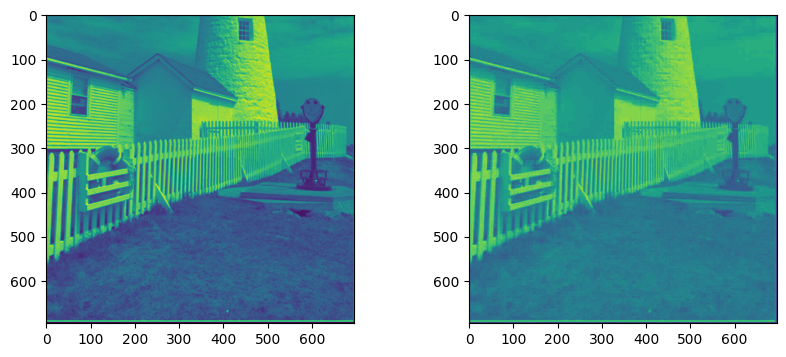

In [147]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(image1)
ax[1].imshow(decoder(blocks))


Is DCT effective for Image compression?

Yes, it is extremely effective, since it transforms the data into something which can be efficiently quantised into a much smaller representation and retain the image with good detail.